## 1. Introduction

Facebook Prophet is a versatile and powerful forecasting algorithm that has gained popularity in various industries. It is specifically designed to handle time series data and has proven to be effective in predicting future trends and patterns. In this notebook, I will be utilizing the Univariate Prophet model to forecast sales for the Walmart dataset. By focusing on the date and weekly sales fields from the Walmart dataset, I aim to capture the underlying patterns and dynamics that influence sales performance specifically for Walmart. The insights gained from this forecasting exercise will be invaluable for demand planning and decision-making at Walmart, enabling optimization of inventory management, effective resource allocation, and informed business strategies tailored to Walmart's retail operations. Through the step-by-step implementation of the one-to-one mapped Univariate Prophet model, this notebook aims to showcase the capabilities of Prophet and its application for accurate sales forecasting within the context of Walmart.

## 2. Methodology

The methodology involves preparing the data by selecting the date and weekly sales fields, and splitting the dataset into training and testing sets. The Prophet model is then fitted on the training set, leveraging its automatic adjustment of parameters based on observed data patterns. Using the fitted model, future sales predictions are generated by specifying the desired forecast periods. To assess the model's performance, Mean Squared Error (MSE) is used as the evaluation metric on both the training and testing sets. This allows for a comprehensive analysis of the model's accuracy and effectiveness in capturing the underlying sales patterns.

## 3. Development of Demand Prediction Model

### 3.1 Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet

### 3.2 Data Collection

This phase involves the collection of multivariate data from a CSV file for the Walmart sales dataset and stores it in a dataframe

In [2]:
# Data Reading
df = pd.read_csv('data/Walmart.csv')

df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


### 3.3 Data Preperation

In this code snippet, the 'Date' column in the DataFrame is converted to datetime format, and the DataFrame is filtered to include only the 'Date' and 'Weekly_Sales' columns for univariate modeling. The data is then grouped by date and the weekly sales are summed, followed by modifying the DataFrame to match Prophet's required format with 'ds' representing the date and 'y' representing the target variable.

In [3]:
# convert date to datetime format
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# get only relevant columns for univariate modeling
df = df[['Date', 'Weekly_Sales']]

# Group the data by date and sum the weekly sales
data = df.groupby('Date', as_index=False).sum()

# Prepare the data for Prophet
data = data.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})
data['ds'] = pd.to_datetime(data['ds'])

### 3.4 Data Splitting

In this phase, the data is split into a Training set (80%) and a Testing set (20%). This division allows for separate subsets of data to be used for model training and evaluation to assess performance.

In [4]:
# Split data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.20, shuffle=False)

# Print the number of records and percentages for each set
print("Train set:")
print("Number of records:", train_data.shape[0])
print("Percentage: {:.0%}".format(train_data.shape[0] / data.shape[0]))

print("\nTest set:")
print("Number of records:", test_data.shape[0])
print("Percentage: {:.0%}".format(test_data.shape[0] / data.shape[0]))

Train set:
Number of records: 114
Percentage: 80%

Test set:
Number of records: 29
Percentage: 20%


### 3.5 Modeling and Evaluation

After the data splitting, the Prophet model is fitted on the training set to capture the trend, seasonality, and holiday effects. The Prophet model optimizes its parameters to minimize the discrepancy between predicted and observed data, thereby improving the accuracy of predictions. By analyzing historical patterns and incorporating pertinent factors, the Prophet model accurately captures the underlying behavior of the time series data. The model's performance is evaluated by comparing the predicted values with the actual values, utilizing the Mean Squared Error (MSE) and the Root Mean Squared Error (RMSE) metric on both the training and testing sets. This evaluation provides valuable insights into the model's accuracy and effectiveness for sales forecasting.

#### Fit Model

In [37]:
# Create and fit the model
model = Prophet(
    seasonality_mode='multiplicative',  # Adjust seasonality mode to 'additive' or 'multiplicative'
    seasonality_prior_scale=20,  # Adjust seasonality strength
    changepoint_prior_scale=1  # Adjust trend flexibility
)
model.add_country_holidays(country_name='US')  # Include holidays as regressors if applicable
model.fit(train_data)

# Make future predictions
future = model.make_future_dataframe(periods=1) # Include number of recursive future predictions
forecast = model.predict(future)

16:33:46 - cmdstanpy - INFO - Chain [1] start processing
16:33:46 - cmdstanpy - INFO - Chain [1] done processing


#### Train Performance

In [42]:
# Calculate MSE and RMSE for Prophet model predictions
mse = mean_squared_error(train_data['y'], train_predictions['yhat'])
rmse = np.sqrt(mse)

# Print MSE and RMSE scores for the Prophet model
print(f"Prophet Model - Train Set MSE: {mse:.2f}")
print(f"Prophet Model - Train Set RMSE: {rmse:.2f}")
print("")

# Calculate moving average
moving_avg_predictions = train_data['y'].rolling(window=7).mean().fillna(0)

# Calculate MSE and RMSE for the moving average baseline
mse_baseline = mean_squared_error(train_data['y'], moving_avg_predictions)
rmse_baseline = np.sqrt(mse_baseline)

# Print MSE and RMSE scores for the moving average baseline
print(f"Moving Average - Train Set MSE: {mse_baseline:.2f}")
print(f"Moving Average - Train Set RMSE: {rmse_baseline:.2f}")
print("")

# Calculate percentage improvement or degradation
percentage_difference = (rmse_baseline - rmse) / rmse_baseline * 100

# Print the percentage improvement or degradation
if rmse < rmse_baseline:
    print(f"The Prophet model performs {percentage_difference:.0f}% better than the moving average model.")
elif rmse > rmse_baseline:
    print(f"The moving average model performs {percentage_difference:.0f}% better than the Prophet model.")
else:
    print("The Prophet model and the moving average model have similar performance.")

Prophet Model - Train Set MSE: 9451525590960.42
Prophet Model - Train Set RMSE: 3074333.36

Moving Average - Train Set MSE: 148777207422951.75
Moving Average - Train Set RMSE: 12197426.26

The Prophet model performs 75% better than the moving average model.


#### Test Performance

In [43]:
# Make predictions on the test set using the Prophet model
test_predictions = model.predict(test_data)

# Calculate MSE and RMSE for Prophet model predictions on the test set
mse_prophet = mean_squared_error(test_data['y'], test_predictions['yhat'])
rmse_prophet = np.sqrt(mse_prophet)

# Print MSE and RMSE scores for the Prophet model on the test set
print(f"Prophet Model - Test Set MSE: {mse_prophet:.2f}")
print(f"Prophet Model - Test Set RMSE: {rmse_prophet:.2f}")
print("")

# Calculate moving average predictions on the test set
moving_avg_predictions_test = test_data['y'].rolling(window=7).mean().fillna(0)

# Calculate MSE and RMSE for the moving average baseline on the test set
mse_baseline = mean_squared_error(test_data['y'], moving_avg_predictions_test)
rmse_baseline = np.sqrt(mse_baseline)

# Print MSE and RMSE scores for the moving average baseline on the test set
print(f"Moving Average - Test Set MSE: {mse_baseline:.2f}")
print(f"Moving Average - Test Set RMSE: {rmse_baseline:.2f}")
print("")

# Calculate percentage improvement or degradation
percentage_difference = (rmse_baseline - rmse) / rmse_baseline * 100

# Print the percentage improvement or degradation
if rmse < rmse_baseline:
    print(f"The Prophet model performs {percentage_difference:.0f}% better than the moving average model.")
elif rmse > rmse_baseline:
    print(f"The moving average model performs {percentage_difference:.0f}% better than the Prophet model.")
else:
    print("The Prophet model and the moving average model have similar performance.")

Prophet Model - Test Set MSE: 7147339290982.06
Prophet Model - Test Set RMSE: 2673450.82

Moving Average - Test Set MSE: 441212881449406.06
Moving Average - Test Set RMSE: 21005067.99

The Prophet model performs 85% better than the moving average model.


#### Performance Visualization

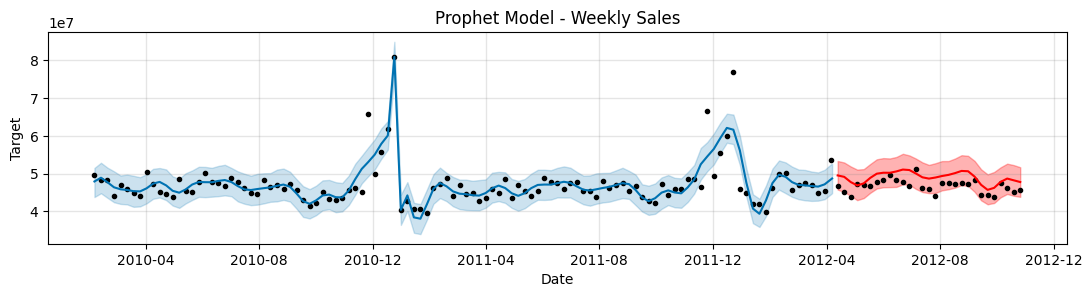

In [45]:
# Plot forecasts and actual values
fig = model.plot(forecast, figsize=(11, 3))
fig.gca().plot(test_data['ds'], test_data['y'], 'k.')

# Plot predicted values and uncertainty interval for the test set
fig.gca().plot(test_predictions['ds'], test_predictions['yhat'], 'r-')
fig.gca().fill_between(test_predictions['ds'], test_predictions['yhat_lower'], test_predictions['yhat_upper'], color='r', alpha=0.3)

plt.title("Prophet Model - Weekly Sales")
plt.xlabel('Date')
plt.ylabel('Target')
plt.show()

## 4. Conclusion

The Prophet model exhibits excellent generalization between the train and test sets, as indicated by its consistent performance across both sets. The Prophet model achieved lower MSE and RMSE values in both the training and test sets, demonstrating its ability to effectively capture the underlying patterns and trends in the data. In comparison, the moving average model showed higher MSE and RMSE values in both sets, indicating its limited capability to generalize to unseen data. The substantial percentage improvements of 75% in the training set and 85% in the test set further emphasize the superiority of the Prophet model over the moving average model. These results highlight the Prophet model's ability to provide more accurate and reliable predictions, making it a preferred choice for demand forecasting in the Walmart dataset.